# Regression Week 5: Feature Selection and LASSO (Interpretation)

In this notebook, you will use LASSO to select features, building on a pre-implemented solver for LASSO (using GraphLab Create, though you can use other solvers). You will:
* Run LASSO with different L1 penalties.
* Choose best L1 penalty using a validation set.
* Choose best L1 penalty using a validation set, with additional constraint on the size of subset.

In the second notebook, you will implement your own LASSO solver, using coordinate descent. 

# Fire up Graphlab Create

In [45]:
import numpy as np
import pandas as pd

dtype_dict = {'bathrooms':float, 'waterfront':int, 'sqft_above':int, 'sqft_living15':float, 'grade':int, 'yr_renovated':int, 'price':float, 'bedrooms':float, 'zipcode':str, 'long':float, 'sqft_lot15':float, 'sqft_living':float, 'floors':float, 'condition':int, 'lat':float, 'date':str, 'sqft_basement':int, 'yr_built':int, 'id':str, 'sqft_lot':int, 'view':int}

sales = pd.read_csv('kc_house_data.csv', dtype=dtype_dict)

# Create new features

As in Week 2, we consider features that are some transformations of inputs.

In [46]:
from math import log, sqrt
sales['sqft_living_sqrt'] = sales['sqft_living'].apply(sqrt)
sales['sqft_lot_sqrt'] = sales['sqft_lot'].apply(sqrt)
sales['bedrooms_square'] = sales['bedrooms']*sales['bedrooms']
sales['floors_square'] = sales['floors']*sales['floors']

* Squaring bedrooms will increase the separation between not many bedrooms (e.g. 1) and lots of bedrooms (e.g. 4) since 1^2 = 1 but 4^2 = 16. Consequently this variable will mostly affect houses with many bedrooms.
* On the other hand, taking square root of sqft_living will decrease the separation between big house and small house. The owner may not be exactly twice as happy for getting a house that is twice as big.

# Learn regression weights with L1 penalty

Let us fit a model with all the features available, plus the features we just created above.

In [47]:
all_features = ['bedrooms', 'bedrooms_square',
            'bathrooms',
            'sqft_living', 'sqft_living_sqrt',
            'sqft_lot', 'sqft_lot_sqrt',
            'floors', 'floors_square',
            'waterfront', 'view', 'condition', 'grade',
            'sqft_above',
            'sqft_basement',
            'yr_built', 'yr_renovated']

Applying L1 penalty requires adding an extra parameter (`l1_penalty`) to the linear regression call in GraphLab Create. (Other tools may have separate implementations of LASSO.)  Note that it's important to set `l2_penalty=0` to ensure we don't introduce an additional L2 penalty.

In [48]:
from sklearn import linear_model

model_all = linear_model.Lasso(alpha = 0, normalize = True)
model_all.fit(sales[all_features],sales['price'])

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  after removing the cwd from sys.path.
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 458084894252119.0, tolerance: 291291676192.12994
  positive)


Lasso(alpha=0, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False)

Find what features had non-zero weight.

In [49]:
filter_1 = model_all.coef_ != 0
np_all_features = np.array(all_features)
np_all_features[filter_1]

array(['bedrooms', 'bedrooms_square', 'bathrooms', 'sqft_living',
       'sqft_living_sqrt', 'sqft_lot', 'sqft_lot_sqrt', 'floors',
       'floors_square', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated'],
      dtype='<U16')

Note that a majority of the weights have been set to zero. So by setting an L1 penalty that's large enough, we are performing a subset selection. 

***QUIZ QUESTION***:
According to this list of weights, which of the features have been chosen? 

# Selecting an L1 penalty

To find a good L1 penalty, we will explore multiple values using a validation set. Let us do three way split into train, validation, and test sets:
* Split our sales data into 2 sets: training and test
* Further split our training data into two sets: train, validation

Be *very* careful that you use seed = 1 to ensure you get the same answer!

In [50]:
testing = pd.read_csv('wk3_kc_house_test_data.csv', dtype=dtype_dict)
training = pd.read_csv('wk3_kc_house_train_data.csv', dtype=dtype_dict)
validation = pd.read_csv('wk3_kc_house_valid_data.csv', dtype=dtype_dict)

make sure to create the 4 features as we did in #1:

In [51]:
testing['sqft_living_sqrt'] = testing['sqft_living'].apply(sqrt)
testing['sqft_lot_sqrt'] = testing['sqft_lot'].apply(sqrt)
testing['bedrooms_square'] = testing['bedrooms']*testing['bedrooms']
testing['floors_square'] = testing['floors']*testing['floors']

training['sqft_living_sqrt'] = training['sqft_living'].apply(sqrt)
training['sqft_lot_sqrt'] = training['sqft_lot'].apply(sqrt)
training['bedrooms_square'] = training['bedrooms']*training['bedrooms']
training['floors_square'] = training['floors']*training['floors']

validation['sqft_living_sqrt'] = validation['sqft_living'].apply(sqrt)
validation['sqft_lot_sqrt'] = validation['sqft_lot'].apply(sqrt)
validation['bedrooms_square'] = validation['bedrooms']*validation['bedrooms']
validation['floors_square'] = validation['floors']*validation['floors']

Next, we write a loop that does the following:
* For `l1_penalty` in [10^1, 10^1.5, 10^2, 10^2.5, ..., 10^7] (to get this in Python, type `np.logspace(1, 7, num=13)`.)
    * Fit a regression model with a given `l1_penalty` on TRAIN data. Specify `l1_penalty=l1_penalty` and `l2_penalty=0.` in the parameter list.
    * Compute the RSS on VALIDATION data (here you will want to use `.predict()`) for that `l1_penalty`
* Report which `l1_penalty` produced the lowest RSS on validation data.

When you call `linear_regression.create()` make sure you set `validation_set = None`.

Note: you can turn off the print out of `linear_regression.create()` with `verbose = False`

In [15]:
l1_penalty = np.logspace(1,7,num=13)

def get_lowest_rss(l1_penalty,training,validation):
    for i in range(len(l1_penalty)):
        model = linear_model.Lasso(alpha = l1_penalty[i], normalize = True)
        model.fit(training.loc[:,all_features], training['price'])
        pred_price = model.predict(validation.loc[:,all_features])
        error = pred_price - validation['price']
        rss = np.dot(error.T,error)
        
        if i == 0:
            lowest_rss = rss
            best_l1_penalty = l1_penalty[i]
            best_model = model
            
        if rss < lowest_rss:
            lowest_rss = rss
            best_l1_penalty = l1_penalty[i]
            best_model = model
            
    return (lowest_rss, best_l1_penalty, best_model)

lowest_rss, best_l1_penalty, best_model = get_lowest_rss(l1_penalty, training, validation)

*** QUIZ QUESTION. *** What was the best value for the `l1_penalty`?

In [14]:
print(lowest_rss)
print(best_l1_penalty)  

398213327300134.94
10.0


***QUIZ QUESTION***
Also, using this value of L1 penalty, how many nonzero weights do you have?

In [18]:
np.count_nonzero(best_model.coef_) + np.count_nonzero(best_model.intercept_)

15

# Limit the number of nonzero weights

What if we absolutely wanted to limit ourselves to, say, 7 features? This may be important if we want to derive "a rule of thumb" --- an interpretable model that has only a few features in them.

In this section, you are going to implement a simple, two phase procedure to achive this goal:
1. Explore a large range of `l1_penalty` values to find a narrow region of `l1_penalty` values where models are likely to have the desired number of non-zero weights.
2. Further explore the narrow region you found to find a good value for `l1_penalty` that achieves the desired sparsity.  Here, we will again use a validation set to choose the best value for `l1_penalty`.

In [19]:
max_nonzeros = 7

## Exploring the larger range of values to find a narrow range with the desired sparsity

Let's define a wide range of possible `l1_penalty_values`:

In [35]:
l1_penalty_values = np.logspace(1, 4, num=20)

Now, implement a loop that search through this space of possible `l1_penalty` values:

* For `l1_penalty` in `np.logspace(1, 4, num=20)`:
    * Fit a regression model with a given `l1_penalty` on TRAIN data. Specify `l1_penalty=l1_penalty` and `l2_penalty=0.` in the parameter list. When you call `linear_regression.create()` make sure you set `validation_set = None`
    * Extract the weights of the model and count the number of nonzeros. Save the number of nonzeros to a list.
        * *Hint: `model['coefficients']['value']` gives you an SArray with the parameters you learned.  If you call the method `.nnz()` on it, you will find the number of non-zero parameters!* 

In [87]:
def get_nonzero(l1_penalty, training):
    num_nonzero = []
    weights = []
    for i in range(len(l1_penalty)):
        model = linear_model.Lasso(alpha = l1_penalty[i], normalize = True)
        model.fit(training.loc[:,all_features], training['price'])
        nonzero = np.count_nonzero(model.coef_) + np.count_nonzero(model.intercept_)
        num_nonzero.append(nonzero)
    return num_nonzero

num_nonzero = get_nonzero(l1_penalty_values, training)
num_nonzero

[15, 15, 15, 15, 13, 12, 11, 10, 7, 6, 6, 6, 5, 3, 3, 2, 1, 1, 1, 1]

Out of this large range, we want to find the two ends of our desired narrow range of `l1_penalty`.  At one end, we will have `l1_penalty` values that have too few non-zeros, and at the other end, we will have an `l1_penalty` that has too many non-zeros.  

More formally, find:
* The largest `l1_penalty` that has more non-zeros than `max_nonzeros` (if we pick a penalty smaller than this value, we will definitely have too many non-zero weights)
    * Store this value in the variable `l1_penalty_min` (we will use it later)
* The smallest `l1_penalty` that has fewer non-zeros than `max_nonzeros` (if we pick a penalty larger than this value, we will definitely have too few non-zero weights)
    * Store this value in the variable `l1_penalty_max` (we will use it later)


*Hint: there are many ways to do this, e.g.:*
* Programmatically within the loop above
* Creating a list with the number of non-zeros for each value of `l1_penalty` and inspecting it to find the appropriate boundaries.

In [90]:
print(num_nonzero.index(6))
print(num_nonzero.index(10))
l1_penalty_min = l1_penalty_values[num_nonzero.index(6)]
l1_penalty_max = l1_penalty_values[num_nonzero.index(10)]

9
7


***QUIZ QUESTION.*** What values did you find for `l1_penalty_min` and `l1_penalty_max`, respectively? 

In [91]:
print(l1_penalty_min)
print(l1_penalty_max)

263.6650898730358
127.42749857031335


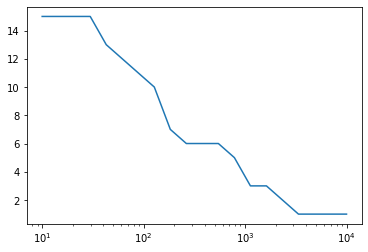

In [92]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(l1_penalty_values, num_nonzero)
plt.xscale('log')

## Exploring the narrow range of values to find the solution with the right number of non-zeros that has lowest RSS on the validation set 

We will now explore the narrow region of `l1_penalty` values we found:

In [93]:
l1_penalty_values = np.linspace(l1_penalty_min,l1_penalty_max,20)

* For `l1_penalty` in `np.linspace(l1_penalty_min,l1_penalty_max,20)`:
    * Fit a regression model with a given `l1_penalty` on TRAIN data. Specify `l1_penalty=l1_penalty` and `l2_penalty=0.` in the parameter list. When you call `linear_regression.create()` make sure you set `validation_set = None`
    * Measure the RSS of the learned model on the VALIDATION set

Find the model that the lowest RSS on the VALIDATION set and has sparsity *equal* to `max_nonzeros`.

In [96]:
def find_final_l1_penalty(l1_penalty, training, validation, all_features, max_nonzeros):
    num_nonzero = []
    rss_validation = []
    lowest_rss_final = None
    lowest_rss_index = None
    lowest_rss_model_coefs = None
    
    for i in range(len(l1_penalty)):
        model = linear_model.Lasso(alpha = l1_penalty[i], normalize = True)
        model.fit(training.loc[:,all_features],training['price'])
        num_nonzero.append(np.count_nonzero(model.coef_)+np.count_nonzero(model.intercept_))
        pred_valid = model.predict(validation.loc[:,all_features])
        errors = validation['price'] - pred_valid
        rss_validation.append(np.dot(errors.T,errors))
        
        if num_nonzero[i] == max_nonzeros:
            if lowest_rss_final is None or rss_validation[i] < lowest_rss_final:
                lowest_rss_final = rss_validation[i]
                lowest_rss_index = i
                lowest_rss_model_coefs = model.coef_
    return (lowest_rss_final, l1_penalty[lowest_rss_index], lowest_rss_model_coefs)

***QUIZ QUESTIONS***
1. What value of `l1_penalty` in our narrow range has the lowest RSS on the VALIDATION set and has sparsity *equal* to `max_nonzeros`?
2. What features in this model have non-zero coefficients?

In [97]:
lowest_rss_final, final_l1_penalty, final_model_coefs = find_final_l1_penalty(l1_penalty_values, training, validation, all_features, max_nonzeros)

In [98]:
print(round(final_l1_penalty,2))

156.11


In [100]:
f_filter = final_model_coefs != 0
np_all_features[f_filter]

array(['bathrooms', 'sqft_living', 'waterfront', 'view', 'grade',
       'yr_built'], dtype='<U16')